In [2]:
import pymc3 as pm
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

C:\Users\james\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

[0 0 0 ... 0 0 0]
79
What is the observed frequency in Group A? 0.0527
Does this equal the true frequency? False


In [4]:
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 74000/74000 [00:27<00:00, 2694.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [5]:
burned_trace["p"]

array([0.05967719, 0.05967719, 0.05967719, ..., 0.05624896, 0.05624896,
       0.05624896])

In [6]:
#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

print(np.mean(observations_A))
print(np.mean(observations_B))

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
0.051333333333333335
0.03866666666666667


In [7]:

# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 82000/82000 [00:34<00:00, 2407.71draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [8]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

C:\Users\james\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


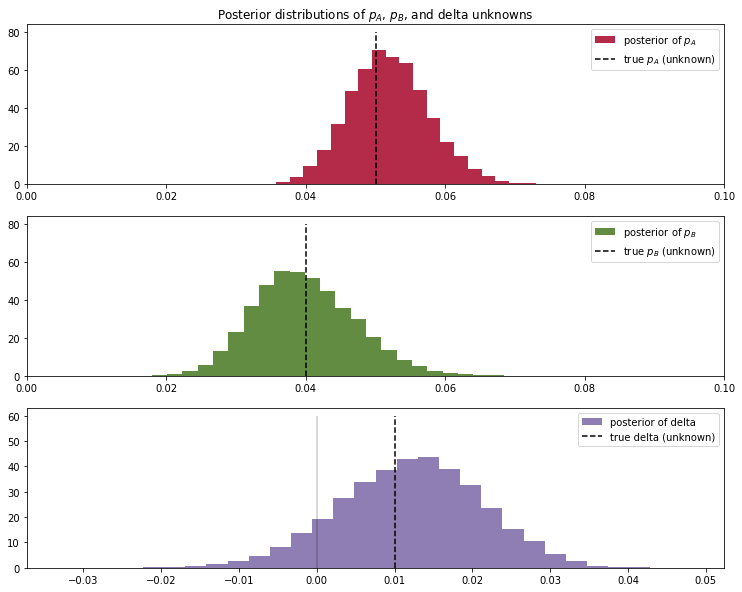

In [9]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [10]:
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.097
Probability site A is BETTER than site B: 0.903


In [11]:
N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)

In [12]:
import theano.tensor as tt
with model:
    true_answers = pm.Bernoulli("truths", p, shape=N, testval=np.random.binomial(1, 0.5, N))
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [13]:
observed_proportion.tag.test_value

array(0.55000001)

In [14]:
X = 35

with model:
    observations = pm.Binomial("obs_bi", N, observed_proportion, observed=X)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
Sampling 4 chains: 100%|███████████████████████████████████████████████████| 162000/162000 [13:17<00:00, 203.20draws/s]
The number of effective samples is smaller than 10% for some parameters.


C:\Users\james\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


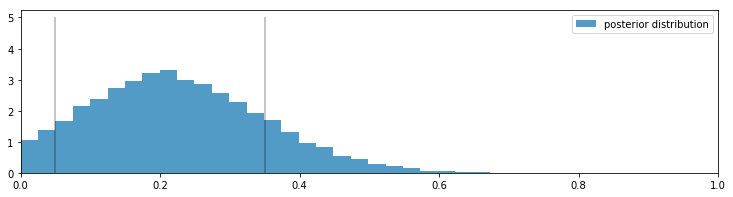

In [15]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

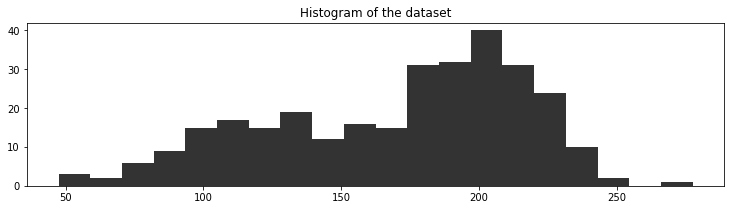

In [16]:
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);

In [17]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[0 0 1 0 0 0 1 0 0 0]


In [18]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])

Random assignments:  [0 0 1 0] ...
Assigned center:  [120. 120. 190. 120.] ...
Assigned standard deviation:  [50. 50. 50. 50.]


In [19]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

C:\Users\james\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
Sampling 4 chains: 100%|███████████████████████████████████████████████████| 102000/102000 [02:30<00:00, 679.23draws/s]
The number of effective samples is smaller than 10% for some parameters.


C:\Users\james\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


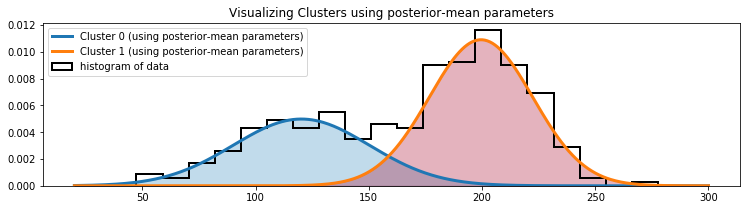

In [25]:
norm = stats.norm
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] else ["#A60628", "#348ABD"]
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

In [22]:
norm_pdf = stats.norm.pdf
center_trace = trace["centers"][25000:]
prev_center_trace = trace["centers"][:25000]
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]
p_trace = trace["p"][25000:]
prev_p_trace = trace["p"][:25000]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("Probability of belonging to cluster 1:", v.mean())

Probability of belonging to cluster 1: 0.008013333333333334


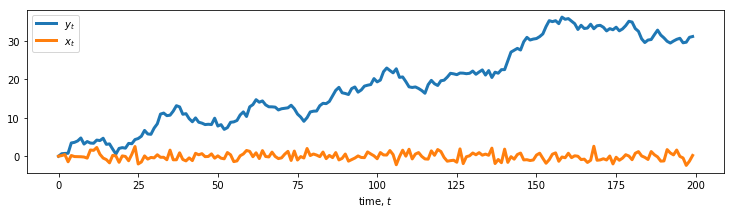

In [32]:
x_t = np.random.normal(0, 1, 200)
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i - 1], 1)

plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend();

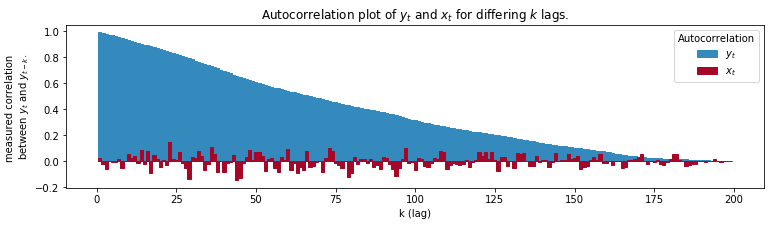

In [33]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");

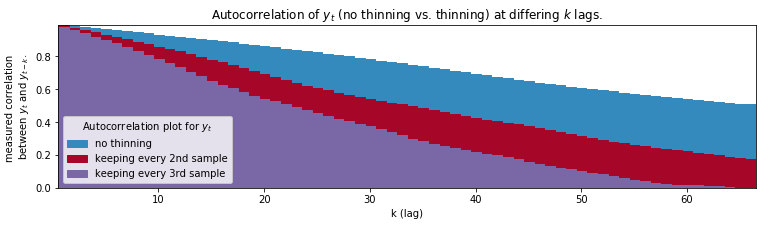

In [34]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");

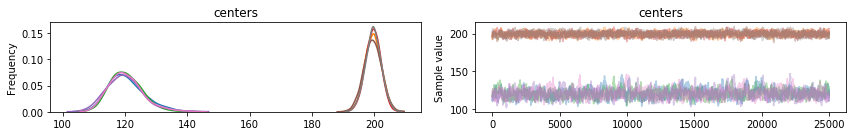

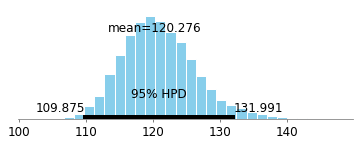

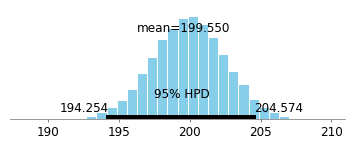

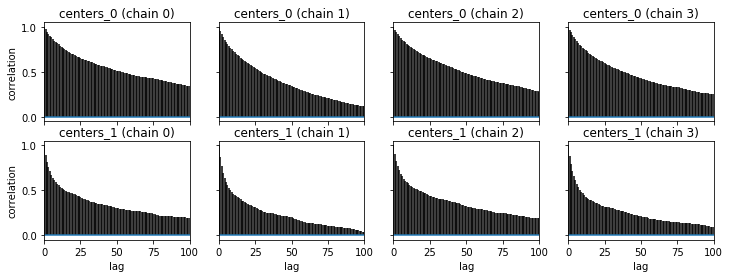

In [35]:
pm.plots.traceplot(trace=trace, varnames=["centers"])
pm.plots.plot_posterior(trace=trace["centers"][:,0])
pm.plots.plot_posterior(trace=trace["centers"][:,1])
pm.plots.autocorrplot(trace=trace, varnames=["centers"]);